# train 2D Unet model. document in neptune 

## detect gpu available

In [1]:
import tensorflow as tf

# check the status of GPU
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.6.2
Num GPUs Available:  1


## set the neptune

In [2]:
# define if the documenting process should go on

DOCUMENT = True
EPOCHS = 1000
batch_size = 16

In [3]:
# neptune document. change the document here

import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

if DOCUMENT:

    run = neptune.init(
        project="leeleeroy/digitalConfocal-zebrafish",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjVjOGVmZi04MjA4LTQ4N2QtOWIzYy05M2YyZWI1NzY3MmEifQ==",
        name = "UNet2D_256_vanilla",
    ) # necessary credentials, the name could be used to reproduce the results 

    # for callbacks in training


    neptune_cbk = NeptuneCallback(run=run, base_namespace='metrics')  # neptune for the training process
    
    # neptune document the hyper param.

    PARAMS = {
              "optimizer": {"learning_rate": 0.0001, "optimizer": "Adam"},
              'epochs': EPOCHS,
              'batch_size':batch_size}

    # log hyper-parameters
    run['hyper-parameters'] = PARAMS
    run["sys/tags"].add(["vanilla", "epochs:" + str(EPOCHS), 'deep512'])

/home/li52/.conda/envs/LM/lib/python3.7/site-packages/neptune/new/internal/utils/git.py:35: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")
/home/li52/.conda/envs/LM/lib/python3.7/site-packages/neptune/new/internal/utils/git.py:35: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")


https://app.neptune.ai/leeleeroy/digitalConfocal-zebrafish/e/DIGZ-19
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


## load in data and inspect with generator

### load in

In [4]:
import os 
import numpy as np
from dataGenerator import imageLoader
import keras
import matplotlib.pyplot as plt
import glob
import random

In [5]:
# visualize func

def visusalizeIMG(n_slice, test_img, test_msk):
    # n_slice = random.randint(0, test_img.shape[2])
    plt.figure(figsize=(8, 8))

    plt.subplot(121)
    plt.imshow(test_img[n_slice,:,:], cmap='gray')
    plt.title('image')
    plt.subplot(122)
    plt.imshow(test_msk[n_slice,:,:], cmap='gray')
    plt.title('mask')
    plt.show()
    
# visualization for two images

def subShow(IMG1, IMG2):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(IMG1, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(IMG2, cmap='gray')
    plt.show()

In [6]:
# define the data path

DATA_PATH = '/home/li52/code/LM/digitalConfocal/data/zebra15/inputData/'  # use the definite path!

# training
train_img_dir = DATA_PATH + 'train/images/'
train_msk_dir = DATA_PATH + 'train/masks/'
train_img_list = sorted(os.listdir(train_img_dir))  # ensure img and msk paired
train_msk_list = sorted(os.listdir(train_msk_dir))

# testing
test_img_dir = DATA_PATH + 'test/images/'
test_msk_dir = DATA_PATH + 'test/masks/'
test_img_list = sorted(os.listdir(test_img_dir))
test_msk_list = sorted(os.listdir(test_msk_dir))

# validation
val_img_dir = DATA_PATH + 'val/images/'
val_msk_dir = DATA_PATH + 'val/masks/'
val_img_list = sorted(os.listdir(val_img_dir))
val_msk_list = sorted(os.listdir(val_msk_dir))

print('train images:', len(train_img_list))
print('val images:', len(val_img_list))
print('test images:', len(test_img_list))

train images: 240
val images: 30
test images: 30


### data generator

In [8]:
from utils import *

# batch_size = 16

train_gen_class = dataGenerator_vanilla(train_img_dir, train_img_list,
                               train_msk_dir, train_msk_list, batch_size)

val_gen_class = dataGenerator_vanilla(val_img_dir, val_img_list,
                             val_msk_dir, val_msk_list, batch_size)


train_img_datagen = train_gen_class.imageLoader()
val_img_datagen = val_gen_class.imageLoader()

image gen: (16, 256, 256) 0.0 0.984313725490196
mask gen: (16, 256, 256) 0.0 1.0 [0. 1.]
slice num: 10


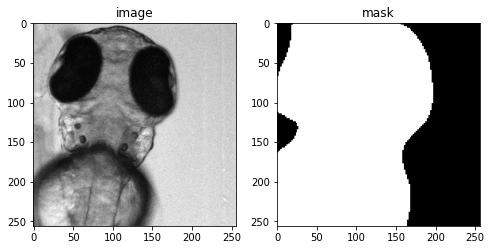

In [9]:
# visualize the data generator

img, msk = train_img_datagen.__next__()

print('image gen:', img.shape, img.min(), img.max())
print('mask gen:', msk.shape, msk.min(), msk.max(), np.unique(msk))

n_slice = random.randint(0, img.shape[0]-1)
# n_slice = 15
print('slice num:', n_slice)
visusalizeIMG(n_slice, img, msk)

## model configuration

### 2D UNet. one channel input

#### compute the weight for dice loss

In [9]:
import pandas as pd

columns = ['0', '1']
df = pd.DataFrame(columns=columns)

train_msk_list = sorted(glob.glob(train_msk_dir + '/*.npy'))

for img in range(len(train_msk_list)):
    
    # print(img)
    temp_image = np.load(train_msk_list[img])
    # temp_image = np.argmax(temp_image, axis=3)  # convert back into images
    
    val, counts = np.unique(temp_image, return_counts=True) # count labels
    zipped = zip(columns, counts)
    counts_dict = dict(zipped)
    
    df = df.append(counts_dict, ignore_index = True)

In [10]:
# calculate the ratio of different labels

label_0 = df['0'].sum()
label_1 = df['1'].sum()

total_labels = label_0 + label_1
n_classes = 2

# class weight calculated: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) 
wt1 = round((total_labels/(n_classes*label_1)), 2)

print(wt0, wt1)

1.26 0.83


#### loss function design

In [11]:
# define the optim and loss
import tensorflow.keras as K
import segmentation_models as sm

LR = 0.0001
optim = K.optimizers.Adam(LR)
wt0, wt1 = 1.26, 0.83


# loss
BCE_loss = sm.losses.BinaryCELoss()
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1]))
focal_loss = sm.losses.CategoricalFocalLoss()
# jaccard_loss = sm.losses.bce_jaccard_loss()

# total_loss = dice_loss*0.005 + (1* focal_loss) + BCE_loss*1
# total_loss = dice_loss*1 + ( focal_loss*1) + BCE_loss*0.005
total_loss = dice_loss*0.05 + (1* focal_loss) + BCE_loss*0.95

# metrics
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]
# metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

Segmentation Models: using `keras` framework.


In [12]:
# 测试用的loss func

import tensorflow.keras.backend as Kb

# # soft dice
# def dice_coef(y_true, y_pred, smooth=100):        
#     y_true_f = Kb.flatten(y_true)
#     y_pred_f = Kb.flatten(y_pred)
#     intersection = Kb.sum(y_true_f * y_pred_f)
#     dice = (2. * intersection + smooth) / (Kb.sum(y_true_f) + Kb.sum(y_pred_f) + smooth)
#     return dice


# def loss_function(y_true, y_pred):
#     dice_loss = -dice_coef(y_true, y_pred)
#     l1_loss = tf.math.reduce_mean(tf.math.abs(y_true - y_pred), axis=(1,2,3))  # tranfer matrix into value
#     SCE = tf.keras.metrics.binary_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1)
    
#     print('SCE shape:', SCE.shape)
    
#     # ssim_loss = tf.image.ssim_multiscale(y_true, y_pred, max_val=1)
    
#     total_loss = dice_loss*0.05 + l1_loss*0.5  + tf.math.reduce_mean(SCE, axis=(1,2))*1  #CE_loss #ssim_loss    # weight should be tuned SCE #
    
    
#     return total_loss


# # soft dice
# def dice_coef(y_true, y_pred, smooth=100):        
#     y_true_f = Kb.flatten(y_true)
#     y_pred_f = Kb.flatten(y_pred)
#     intersection = Kb.sum(y_true_f * y_pred_f)
#     dice = (2. * intersection + smooth) / (Kb.sum(y_true_f) + Kb.sum(y_pred_f) + smooth)
#     return dice


# def loss_function(y_true, y_pred):
#     dice_loss = -dice_coef(y_true, y_pred)
#     # l1_loss = tf.math.reduce_mean(tf.math.abs(y_true - y_pred), axis=(1,2,3))  # tranfer matrix into value
#     l1_loss = tf.math.reduce_mean(tf.math.abs(y_true - y_pred))
#     SCE = tf.keras.metrics.binary_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1)
    
#     print('SCE shape:', SCE.shape)
    
#     # ssim_loss = tf.image.ssim_multiscale(y_true, y_pred, max_val=1)
    
#     total_loss = dice_loss*0.05 + l1_loss*0.5  + tf.math.reduce_mean(SCE)*1  #CE_loss #ssim_loss    # weight should be tuned SCE #
    
    
#     return total_loss

In [13]:
# compile the model

# from models.simple2DUnet_256 import *
from models.simple2DUnet_512 import *
# from models.simple2DUnet_1024 import *

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model.compile(optimizer=optim, loss=total_loss, metrics=metrics)
# model.compile(optimizer=optim, loss=loss_function, metrics=[dice_coef])  # self_define loss
# model.compile(optimizer=optim, loss=loss_function, metrics=metrics)

# print(model.summary)
print('input shape:', model.input_shape)
print('output shape:', model.output_shape)

/home/li52/.conda/envs/LM/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,
2022-08-19 00:52:44.516293: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable 

c1 shape (None, 256, 256, 16)
conc shape: (None, 16, 16, 256) (None, 16, 16, 256)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 256, 256, 16) 32          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        instance_normalization[0][0]     
____________

## train

In [14]:
import tensorflow.keras as k

# steps and epochs
steps_per_epoch = len(train_img_list) // batch_size
val_steps_per_epoch = len(val_img_list) // batch_size

print('train steps/epoch', steps_per_epoch)
print('val steps/epoch', steps_per_epoch)

# call backs for documentation

if DOCUMENT:
    callbacks = [
        # k.callbacks.EarlyStopping(patience=15, monitor='val_loss'),
        neptune_cbk, 
        k.callbacks.TensorBoard(log_dir = './tensorboard/UNet2D')  # save in new folder in hemera. Also update in neptune
    ]
else:
    callbacks = [
        # k.callbacks.EarlyStopping(patience=15, monitor='val_loss'),
        k.callbacks.TensorBoard(log_dir = './tensorboard/UNet2D')  
    ]

train steps/epoch 15
val steps/epoch 15


2022-08-19 00:52:46.753768: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-19 00:52:46.753796: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-08-19 00:52:46.753848: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-08-19 00:52:46.754239: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /trinity/shared/pkg/numlib/mpfr/3.1.4/lib:/trinity/shared/pkg/numlib/mpc/1.0.3/lib:/trinity/shared/pkg/numlib/gmp/6.1.2/lib:/trinity/shared/pkg/compiler/gcc/7.3.0/lib64:/trinity/shared/pkg/compiler/gcc/7.3.0/lib:/trinity/shared/pkg/devel/cuda/11.2/lib64:/trinity/shared/pkg/devel/cuda/11.2/lib:/trinity/shared/pkg/devel/anaconda/2021.11/lib:/trinity/shared/pkg/devel/python/3.10.4/lib/python3.10:/trinity/shared/pkg/d

In [15]:
# 测试用

# train per steps. inspect the loss is correct.
# caution, this training will continue

# NUM_STEPS = 4000

# for step in range(NUM_STEPS):
    
#     img, msk = train_img_datagen.__next__()
    
#     loss = model.train_on_batch(img, msk.astype('float64'))  # batch=1
    
#     print(step, loss)
    
# #     if step % 1000:
# #         model.save_weights('./model_savedG.hdf5')
        
#     if step % 100 == 0:
#         prediction = model.predict(img, batch_size=1)
#         plt.imshow(prediction[0,...],cmap='gray')
#         plt.show()
#         plt.close('all')
        

In [16]:
# train with keras model

history = model.fit(train_img_datagen,
                   steps_per_epoch=steps_per_epoch,
                   epochs=EPOCHS,
                   verbose=1, # ??
                   validation_data=val_img_datagen,
                   validation_steps=val_steps_per_epoch,
                   callbacks=callbacks)

Epoch 1/1000


2022-08-19 00:52:46.859279: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-19 00:52:51.706369: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


 3/15 [=====>........................] - ETA: 1s - loss: 0.5589 - accuracy: 0.7078 - iou_score: 0.6401

2022-08-19 00:52:54.401245: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-19 00:52:54.401290: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-08-19 00:52:54.401412: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2022-08-19 00:52:54.470885: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-19 00:52:54.471010: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2022-08-19 00:52:54.481181: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-08-19 00:52:54.484466: I tensorflow

15/15 [==============================] - 10s 162ms/step - loss: 0.5337 - accuracy: 0.7540 - iou_score: 0.6696 - val_loss: 0.4803 - val_accuracy: 0.7999 - val_iou_score: 0.7144
Epoch 2/1000
15/15 [==============================] - 1s 72ms/step - loss: 0.4587 - accuracy: 0.8142 - iou_score: 0.7339 - val_loss: 0.3947 - val_accuracy: 0.8570 - val_iou_score: 0.8006
Epoch 3/1000
15/15 [==============================] - 1s 72ms/step - loss: 0.3626 - accuracy: 0.8700 - iou_score: 0.8141 - val_loss: 0.2970 - val_accuracy: 0.8971 - val_iou_score: 0.8521
Epoch 4/1000
15/15 [==============================] - 1s 77ms/step - loss: 0.2864 - accuracy: 0.8948 - iou_score: 0.8476 - val_loss: 0.2491 - val_accuracy: 0.9104 - val_iou_score: 0.8704
Epoch 5/1000
15/15 [==============================] - 1s 75ms/step - loss: 0.2498 - accuracy: 0.9037 - iou_score: 0.8595 - val_loss: 0.2199 - val_accuracy: 0.9185 - val_iou_score: 0.8812
Epoch 6/1000
15/15 [==============================] - 1s 70ms/step - loss: 0

In [17]:
MODEL_PATH = './models_weight/'
SVAED_MODEL_NAME = MODEL_PATH + 'simple2D_512' + '_' + str(EPOCHS) + '.hdf5'

model.save(SVAED_MODEL_NAME)

### visualize the train process

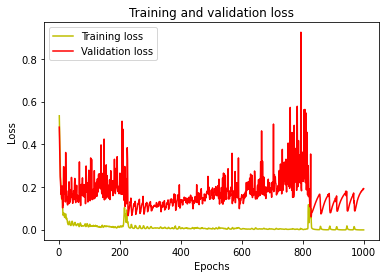

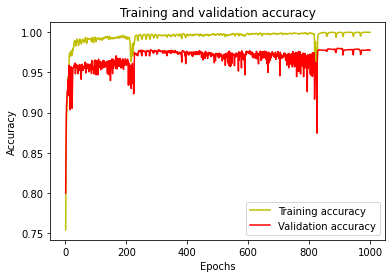

In [18]:
# visualize

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# predict on test dataset

In [19]:
# load in the model

MODEL_PATH = './models_weight/'

from keras.models import load_model
my_model = load_model(SVAED_MODEL_NAME, compile=False)

### generator for test

In [10]:
# test generator

from utils import *

batch_size_test = 32

test_gen_class = dataGenerator_vanilla(test_img_dir, test_img_list,
                               test_msk_dir, test_msk_list, batch_size_test)

test_img_datagen = test_gen_class.imageLoader()

image gen: (30, 256, 256) 0.0 1.0
mask gen: (30, 256, 256) 0.0 1.0 [0. 1.]
slice num: 4


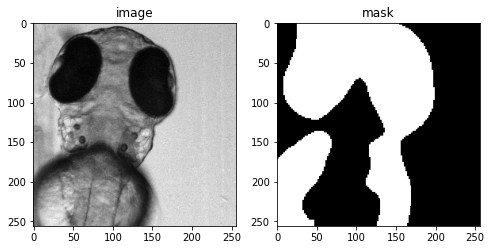

In [11]:
# inspect generator data

img_test, msk_test = test_img_datagen.__next__()

print('image gen:', img_test.shape, img_test.min(), img_test.max())
print('mask gen:', msk_test.shape, msk_test.min(), msk_test.max(), np.unique(msk_test))

n_slice = random.randint(0, img_test.shape[0]-1)
# n_slice = 15
print('slice num:', n_slice)
visusalizeIMG(n_slice, img_test, msk_test)

### predict

In [22]:
# prediction

pred_test = model.predict(img_test)
print(pred_test.shape, pred_test.min(), pred_test.max())


(30, 256, 256, 1) 0.0 1.0


slice num: 11


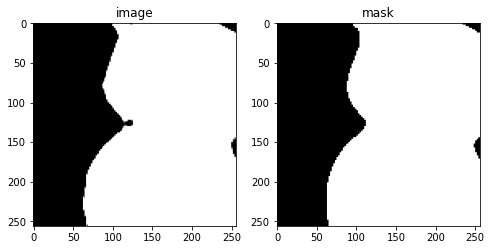

In [23]:
# visualization

n_slice = random.randint(0, pred_test.shape[0]-1)
# n_slice = 15
print('slice num:', n_slice)
visusalizeIMG(n_slice, pred_test.squeeze(), msk_test)

In [24]:
# calculate the IOU for one test batch

from tensorflow.keras.metrics import MeanIoU

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)

# pred_test_argmax = pred_test.squeeze()
IOU_keras.update_state(pred_test.squeeze(), msk_test)
print("pred Mean IoU =", IOU_keras.result().numpy())

pred Mean IoU = 0.8341606


### document the test result

255.0


(-0.5, 797.5, 255.5, -0.5)

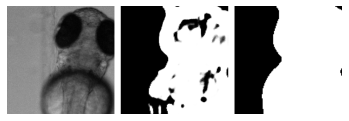

In [25]:
# test one image

i = 9

tIMG = img_test[i,...] # input
tPred = pred_test.squeeze()[i,...] # prediction
tMask = msk_test[i,...] # GT

bar = np.ones((tIMG.shape[0], 15))   # lines
combTemp = np.concatenate((tIMG, bar, tPred, bar, tMask), axis=1) * 255

print(combTemp.max())

plt.imshow(combTemp, cmap='gray')
plt.axis('off')

In [26]:
# document in neptune

for i in range(pred_test.shape[0]):
    tIMG = img_test[i,...] # input
    tPred = pred_test.squeeze()[i,...] # prediction
    tMask = msk_test[i,...] # GT
    
    bar = np.ones((tIMG.shape[0], 15))   # lines
    combTemp = np.concatenate((tIMG, bar, tPred, bar, tMask), axis=1) # upload [0, 1]
    
    
    # upload the test images to neptune
    if DOCUMENT:
        # upload the test results into neptune with handle 'description'
        run["test/sample_images"].log(neptune.types.File.as_image(combTemp), name=str(i), description='test images')  
    

## stop neptune

In [27]:
# stop the neptune
if DOCUMENT:
    run.stop() 

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 73 operations to synchronize with Neptune. Do not kill this process.


All 73 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/leeleeroy/digitalConfocal-zebrafish/e/DIGZ-16


## predict a whole stack

### load in the image stacks

In [28]:
# load in

preSegStacks = np.load('/bigdata/casus/MLID/RuiLi/Data/LM/segStacks/segStacks_170411_24.npy')
print(preSegStacks.shape, preSegStacks.min(), preSegStacks.max())

(4, 20, 256, 256) 0 255


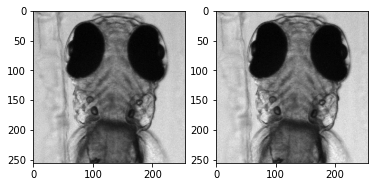

In [29]:
# visualize
import random

n_slice = random.randint(0, preSegStacks.shape[1])
subShow(preSegStacks[0,n_slice,:,:,], preSegStacks[0,n_slice + 1,:,:,])

### predict in model

In [30]:
# predict per stacks

predictStacks = []

for stack in range(preSegStacks.shape[0]):
    stackTemp = preSegStacks[stack,...] / 255 # uint8 -> [0, 1]
    predTemp = model.predict(stackTemp)
    
    predictStacks.append(predTemp.squeeze())
    
predictStacks = np.asarray(predictStacks)
print(predictStacks.shape, predictStacks.min(), predictStacks.max())

(4, 20, 256, 256) 0.0 1.0


slice num: 7


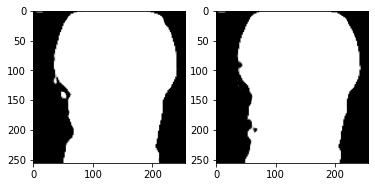

In [31]:
# visualize

n_slice = random.randint(0, predictStacks.shape[1]-1)
print('slice num:', n_slice)
subShow(predictStacks[0,n_slice,:,:,], predictStacks[0,n_slice + 1,:,:,])

### take seg pixels from mask

In [32]:
# seg one stack images [NUM, W, H]. msk as bool, img as [0, 1]

import numpy as np

def segPixels(mskStack, imgStack):
    
    segStack = []
    for num in range(mskStack.shape[0]):
        
        mskTemp = mskStack[num,...]
        imgTemp = imgStack[num,...]
        
        segTemp = np.zeros(imgTemp.shape)
        # print(mskTemp.shape)
        
        posTemp = np.where(mskTemp)

        for i in range(posTemp[0].shape[0]):
            segTemp[posTemp[0][i],posTemp[1][i]] = imgTemp[posTemp[0][i],posTemp[1][i]]
        
        segStack.append(segTemp)
        
    return np.asarray(segStack)
    

slice num: 15


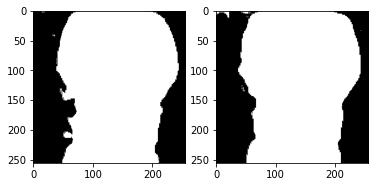

In [33]:
# binarize the mask stacks

predictStacks = predictStacks > 0.2

n_slice = random.randint(0, predictStacks.shape[1]-1)
print('slice num:', n_slice)
subShow(predictStacks[0,n_slice,:,:,], predictStacks[0,n_slice + 1,:,:,])

In [34]:
# seg all stacks

segStacks = []

for stack in range(predictStacks.shape[0]):
    
    tempMskStack = predictStacks[stack]
    tempImgStack = preSegStacks[stack]
    
    tempSegStack = segPixels(tempMskStack, tempImgStack)
    
    segStacks.append(tempSegStack)

segStacks = np.asarray(segStacks)
print(segStacks.shape)

(4, 20, 256, 256)


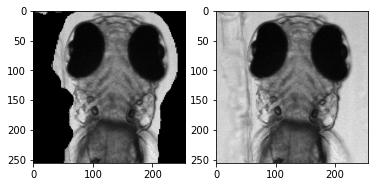

In [35]:
# visualize
import random

n_stack = 0
n_slice = random.randint(0, segStacks.shape[1]-1)

subShow(segStacks[n_stack, n_slice, :, :], preSegStacks[n_stack, n_slice, :, :])

### save image for offline visualize

In [36]:
# save as tif for offline visualize

import numpy as np
from tifffile import imsave

SEG_PATH = './reports/UNet2D_vanilla/'

for stack in range(segStacks.shape[0]):
    
    tempStack = segStacks[stack,...]   
    imsave(SEG_PATH + str(stack) +'_seg_result_deep_512' + '.tif', tempStack)